# Introduction

## Context

* Planete OUI offers green electricity supply with prices adapted to the consumption profiles of its clients. 
* The electricity prices are highly variable during time (depending on the market, the global consumption and its client needs).
* The consumption profile of an installation has to be appraised to compute the best estimation of supply tarifs 
    * Most sites have a consumption varying strongly with temperature because of electrical heating systems.
    * Except industrial installations because their consumption might be highly related their uses

The 1st objectives are to __analyze thermosensitivity uses and / or other factors (times series...)__ affecting consumption 

Based on:
* the potential client historical consumption data (i.e its profile)
* electricity prices 
* a given percentile used to cover supply costs for different scenarios
the 2nd objective of Planète OUI is to compute a distribution of supply costs in €/MWh.  

## Planète OUI needs

Extrapolation of one or several years consumption data rebuilt from a single year of measured data supplied by the client (in order to be Tcombined with electricity prices) and to get a larger data set of analysis.

## Data

* The client’s data is often incomplete and spread over a relatively short period.
* 3 datasets:
    * x_train : input data of the training set
    * y_train : output data of the training set
    * x_test : input data of the testing set
* Features:
    * "ID": Data point ID;
    * "timestamp": Complete timestamps with year, month, day and hour, in local time (CET and CEST);
    * "temp1", "temp2", "meannationaltemp": Local and mean national temperatures (°C);
    * "humidity1", "humidity2": Local relative humidities (%);
    * "loc1", "loc2" "locsecondary1", "locsecondary2", "locsecondary3": the coordinates of the studied and secondary sites, in decimal degrees and of the form (latitude, longitude).
    * "consumptionsecondary1", "consumptionsecondary2", "consumptionsecondary3": the consumption data of three secondary sites, whose correlations with studied sites may be of use (kWh). Indeed, the two studied sites and the three secondary sites are used for the same purposes; The output data of the model to be developed takes the following form:
        * "ID": Data point ID;
        * "consumption1", "consumption2": the consumption data of the two studied sites (kWh).

Relative humidities are provided with temperature data because they represent variables of importance for electricity consumption: humidity indeed strongly available for all. It has
influences thermal comfort. To replicate operational conditions, some temperature integrated BCM Energy’s
and humidity data points will be missing. The imputation method must be carefully perimeter in 2017.
considered. The "consumptionsecondaryi" variables are the consumption data of several sites with metering power higher than 250 kVA of the Planète OUIs portfolio.

This correlation of the various sites consumptions shall be studied to precise data
completion or interpolation. Timestamps may be expressed as month or day of year,
day of week and hours, to study the impact of annual, weekly and daily seasonalities.
Particular attention should be paid to national holidays processing.

## Challenge goal

Prediction of the consumption of two given sites during a year, based on measured data of other profiles.

---

# First data insight

## Basic infos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 100)

In [3]:
from sklearn.preprocessing import MinMaxScaler
import folium

In [4]:
input_dir = os.path.join('..', 'input')
output_dir = os.path.join('..', 'output')
print(os.listdir(input_dir))

['input_training_ssnsrY0.csv', 'Screenshot from 2019-05-28 10-48-59.png', 'input_test_cdKcI0e.csv', 'vacances-scolaires.csv', 'jours_feries_seuls.csv', 'BCM_custom_metric.py', 'output_training_Uf11I9I.csv']


In [5]:
# each id is unique so we can use this column as index
df = pd.read_csv(os.path.join(input_dir, 'input_training_ssnsrY0.csv'), index_col='ID')
df.iloc[23:26]

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
ID,,,,,,,,,,,,,,
23,2016-11-01T23:00:00.0,10.8,NaN,11.1,87.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,67,162
24,2016-11-02T00:00:00.0,10.8,NaN,11.1,86.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",144,75,161
25,2016-11-02T01:00:00.0,10.5,NaN,11.0,81.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,65,161


In [6]:
df_out = pd.read_csv(os.path.join('..', 'input', 'output_training_Uf11I9I.csv'), index_col='ID')
df_out.head()

,consumption_1,consumption_2
ID,,
0,100,93
1,101,94
2,100,96
3,101,95
4,100,100


In [7]:
df.shape, df_out.shape

((8760, 14), (8760, 2))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 14 columns):
timestamp                  8760 non-null object
temp_1                     8589 non-null float64
temp_2                     8429 non-null float64
mean_national_temp         8760 non-null float64
humidity_1                 8589 non-null float64
humidity_2                 8428 non-null float64
loc_1                      8760 non-null object
loc_2                      8760 non-null object
loc_secondary_1            8760 non-null object
loc_secondary_2            8760 non-null object
loc_secondary_3            8760 non-null object
consumption_secondary_1    8760 non-null int64
consumption_secondary_2    8760 non-null int64
consumption_secondary_3    8760 non-null int64
dtypes: float64(5), int64(3), object(6)
memory usage: 1.0+ MB


## Missing or irrelevant values

In [9]:
df.isnull().sum()

timestamp                    0
temp_1                     171
temp_2                     331
mean_national_temp           0
humidity_1                 171
humidity_2                 332
loc_1                        0
loc_2                        0
loc_secondary_1              0
loc_secondary_2              0
loc_secondary_3              0
consumption_secondary_1      0
consumption_secondary_2      0
consumption_secondary_3      0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
#sns.pairplot(df_viz.select_dtypes(['int64', 'float64']))#.apply(pd.Series.nunique, axis=0)

## Transforming time informations 

In [12]:
def transform_datetime_infos(data_frame):
    data_frame['datetime'] = pd.to_datetime(data_frame['timestamp'])
    data_frame['month'] = data_frame['datetime'].dt.month
    data_frame['week of year'] = data_frame['datetime'].dt.weekofyear
    data_frame['day of year'] = data_frame['datetime'].dt.dayofyear
    data_frame['day'] = data_frame['datetime'].dt.weekday_name
    data_frame['hour'] = data_frame['datetime'].dt.hour
    
    # for merging purposes
    data_frame['date'] = data_frame['datetime'].dt.strftime('%Y-%m-%d')
    
    return data_frame

In [13]:
df = transform_datetime_infos(df)
df.head(3)

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,datetime,month,week of year,day of year,day,hour,date
ID,,,,,,,,,,,,,,,,,,,,,
0,2016-11-01T00:00:00.0,8.3,NaN,11.1,95.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168,2016-11-01 00:00:00,11,44,306,Tuesday,0,2016-11-01
1,2016-11-01T01:00:00.0,8.0,NaN,11.1,98.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,60,162,2016-11-01 01:00:00,11,44,306,Tuesday,1,2016-11-01
2,2016-11-01T02:00:00.0,6.8,NaN,11.0,97.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",142,60,164,2016-11-01 02:00:00,11,44,306,Tuesday,2,2016-11-01


## Considered sites

In [14]:
# Number of unique classes in each object column # Check the nb of sites
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

timestamp          8759
loc_1                 1
loc_2                 1
loc_secondary_1       1
loc_secondary_2       1
loc_secondary_3       1
day                   7
date                365
dtype: int64

In [15]:
for i in ['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3']:
    print('site : ', i, 'coordinates : ', df[i][0])

site :  loc_1 coordinates :  (50.633, 3.067)
site :  loc_2 coordinates :  (43.530, 5.447)
site :  loc_secondary_1 coordinates :  (44.838, -0.579)
site :  loc_secondary_2 coordinates :  (47.478, -0.563)
site :  loc_secondary_3 coordinates :  (48.867, 2.333)


In [16]:
# Create a map centered at the given latitude and longitude
france_map = folium.Map(location=[47,1], zoom_start=6)

# Add markers with labels
for i in ['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3']:
    temp_str = df[i][0].strip('(').strip(')').strip(' ')
    temp_str1, temp_str2 = temp_str.split(', ')
    folium.Marker([float(temp_str1), float(temp_str2)], popup=None, tooltip=i).add_to(france_map) 
    
# Display the map
display(france_map)

* loc_1 is in the north near Lille.
* loc_1 is in the south east near Marseille.
* loc_secondary_1 is in the south west near Bordeaux.
* loc_secondary_2 is in the west near Le Mans.
* loc_secondary_3 is in the north near Paris.

---

# Exploratory Data Analysis

## Distribution of consumption

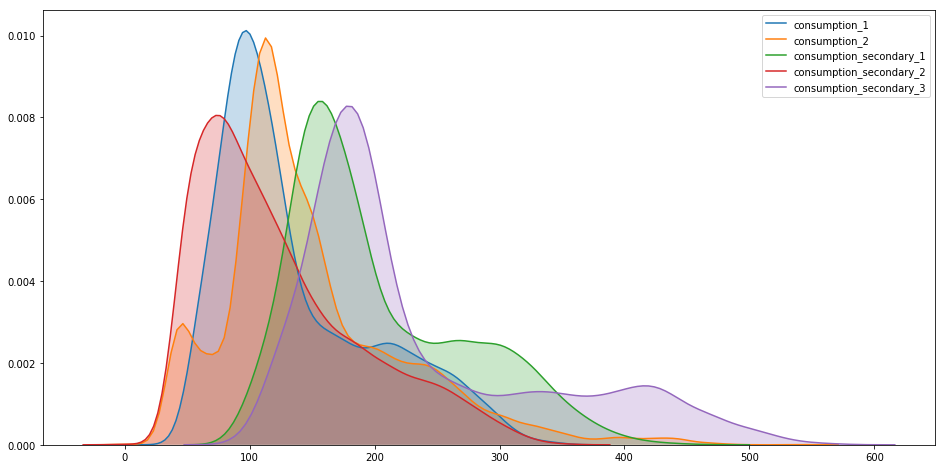

In [17]:
plt.figure(figsize=(16, 8))
sns.kdeplot(df_out['consumption_1'], shade=True) #, label = 'consumption_1')
sns.kdeplot(df_out['consumption_2'], shade=True) #, label = 'consumption_2')
sns.kdeplot(df['consumption_secondary_1'], shade=True) #, label = 'consumption_1')
sns.kdeplot(df['consumption_secondary_2'], shade=True) #, label = 'consumption_1')
sns.kdeplot(df['consumption_secondary_3'], shade=True) #, label = 'consumption_1')
plt.show()

## Consumption variation during time

In [18]:
df.groupby(['hour'])['consumption_secondary_1'].mean().values

array([160.77534247, 160.8739726 , 160.5260274 , 160.83835616,
       161.46027397, 168.88767123, 191.30136986, 210.9369863 ,
       228.49863014, 248.32328767, 256.64657534, 256.21369863,
       240.23287671, 238.76438356, 244.09041096, 242.99178082,
       237.61643836, 227.66027397, 208.08767123, 195.21917808,
       182.35068493, 166.50958904, 161.92054795, 161.87671233])

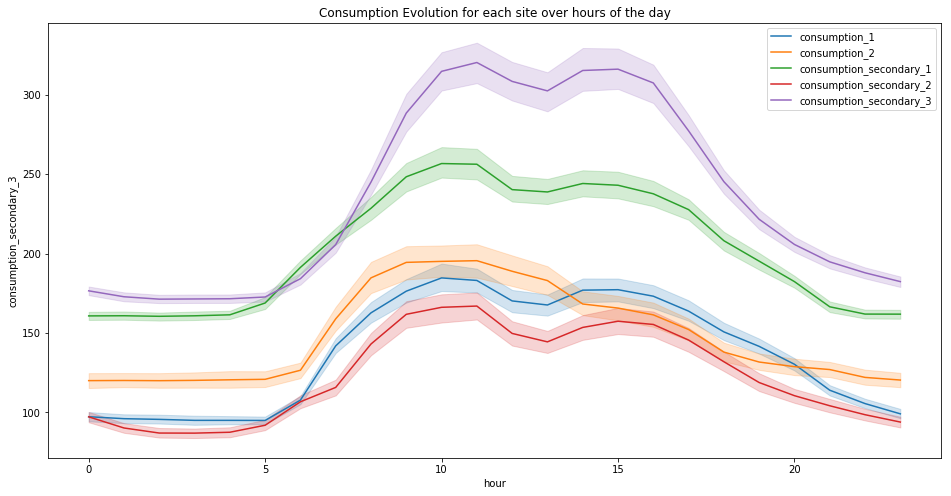

In [19]:
df_viz = pd.concat((df, df_out), axis=1)
plt.figure(figsize=(16, 8))
plt.title("Consumption Evolution for each site over hours of the day")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(x="hour", y=c, data=df_viz, label=c)
plt.show()

The graph above clearly shows that the electricity consumption is higher during working hours of the day.

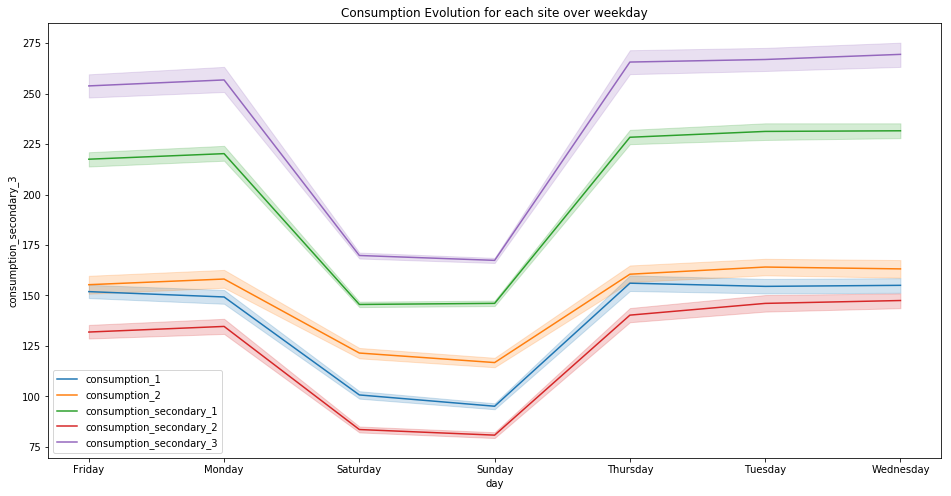

In [20]:
plt.figure(figsize=(16, 8))
plt.title("Consumption Evolution for each site over weekday")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(x="day", y=c, data=df_viz, label=c)
plt.show()

The consumption is lower during the week-end. So we can deduce that those sites are not housings.

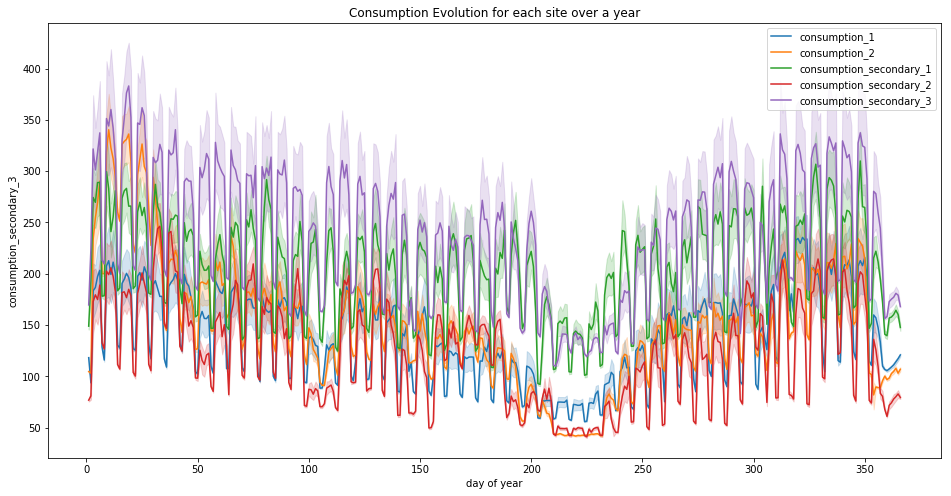

In [21]:
plt.figure(figsize=(16, 8))
plt.title("Consumption Evolution for each site over a year")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(x="day of year", y=c, data=df_viz, label=c)
plt.show()

We can see that globally the mean consumption decreases until the summer, then increases until the end of the year. 

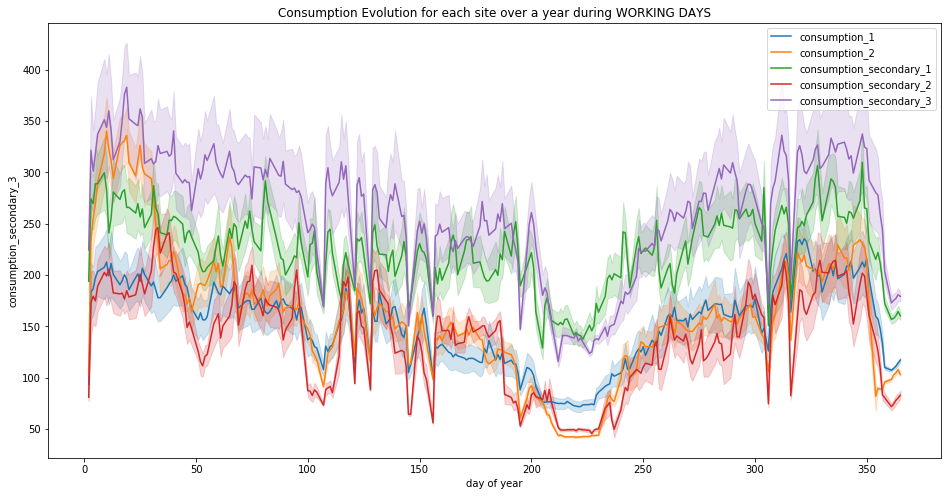

In [22]:
plt.figure(figsize=(16, 8))
plt.title("Consumption Evolution for each site over a year during WORKING DAYS")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(x="day of year", y=c, data=df_viz[~df_viz['day'].isin(['Saturday', 'Sunday'])], label=c)
plt.show()

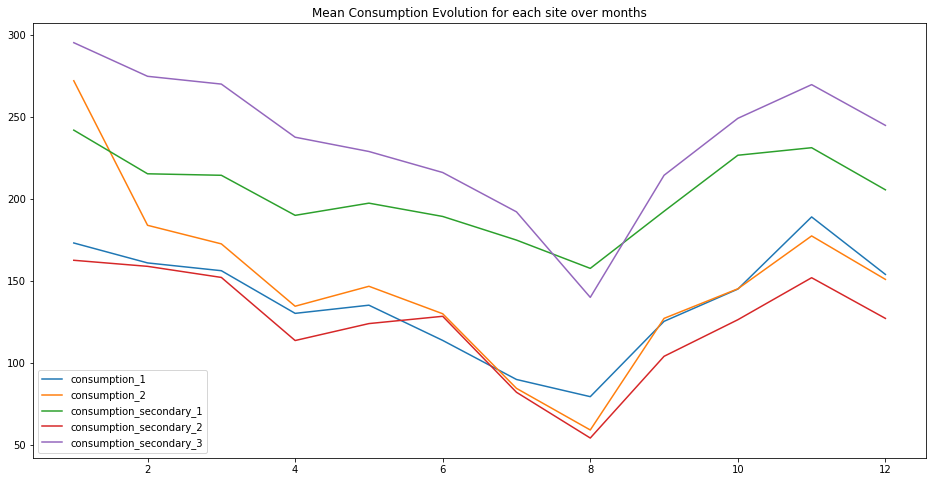

In [23]:
plt.figure(figsize=(16, 8))
plt.title("Mean Consumption Evolution for each site over months")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(data=df_viz.groupby(['month'])[c].mean(), label=c)
plt.show()

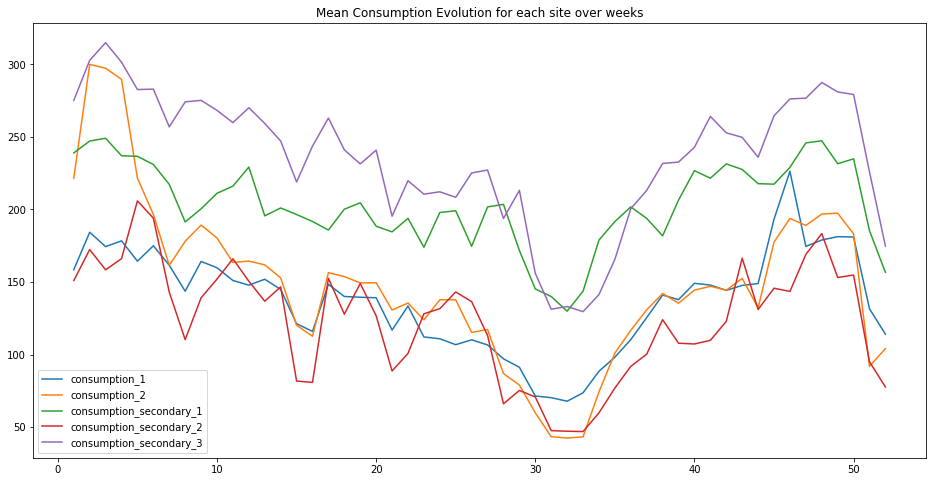

In [24]:
plt.figure(figsize=(16, 8))
plt.title("Mean Consumption Evolution for each site over weeks")
for c in ['consumption_1', 'consumption_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']:
    sns.lineplot(data=df_viz.groupby(['week of year'])[c].mean(), label=c)
plt.show()

/home/sunflowa/Anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


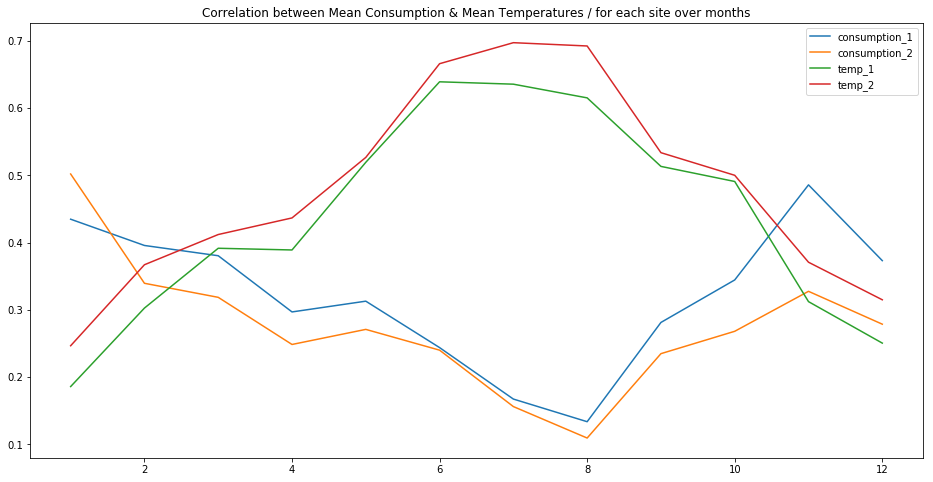

In [25]:
temp_consumption_cols = ['consumption_1', 'consumption_2', 'temp_1', 'temp_2']
df_viz[temp_consumption_cols] = MinMaxScaler().fit_transform(df_viz[temp_consumption_cols])

plt.figure(figsize=(16, 8))
plt.title("Correlation between Mean Consumption & Mean Temperatures / for each site over months")
for c in temp_consumption_cols:
    sns.lineplot(data=df_viz.groupby(['month'])[c].mean(), label=c)
plt.show()

Electricity consumption and temperatures seem to be negatively correlated.

---

# Features Engineering

## Special dates - non working days "Jours fériés" 
(credits: Antoine Augusti https://github.com/AntoineAugusti/jours-feries-france)

In [26]:
jf = pd.read_csv(os.path.join(input_dir, 'jours_feries_seuls.csv')).drop(columns=['nom_jour_ferie'])
# the date column is kept as a string for merging purposes
jf['est_jour_ferie'] = jf['est_jour_ferie'].astype('int')
jf.tail()

,date,est_jour_ferie
1102,2050-07-14,1
1103,2050-08-15,1
1104,2050-11-01,1
1105,2050-11-11,1
1106,2050-12-25,1


In [27]:
jf.est_jour_ferie.unique()

array([1])

## Holidays 
(credits: Antoine Augusti https://www.data.gouv.fr/fr/datasets/vacances-scolaires-par-zones/)

In [28]:
holidays = pd.read_csv(os.path.join(input_dir, 'vacances-scolaires.csv')).drop(columns=['nom_vacances'])
# the date column is kept as a string for merging purposes
for col in ['vacances_zone_a', 'vacances_zone_b', 'vacances_zone_c']:
    holidays[col] = holidays[col].astype('int')
holidays.tail()

,date,vacances_zone_a,vacances_zone_b,vacances_zone_c
11318,2020-12-27,0,0,0
11319,2020-12-28,0,0,0
11320,2020-12-29,0,0,0
11321,2020-12-30,0,0,0
11322,2020-12-31,0,0,0


## Sunlight hours
work in progress, more to come in the next days...stay tuned :)

## Merging all infos

In [29]:
def merge_infos(data_frame):
    data_frame = pd.merge(data_frame, holidays, on='date', how='left')
    data_frame = pd.merge(data_frame, jf, on='date', how='left')
    return data_frame

In [30]:
df = merge_infos(df)
df.vacances_zone_a.value_counts()/24

0    243.958333
1    121.041667
Name: vacances_zone_a, dtype: float64

In [31]:
df.est_jour_ferie.value_counts()/24

1.0    11.0
Name: est_jour_ferie, dtype: float64

# Cleaning Data

In [32]:
def cleaning_data(data_frame):

    # The Nan values of the column "est_jour_ferie" correspond to working days 
    # because in the dataset merged with, there is only non working days 
    data_frame['est_jour_ferie'] = data_frame['est_jour_ferie'].fillna(0)
    
    # At first, missing values in the temperatures and humidity columns are replaced by the median ones
    # later another approach with open data of means of the corresponding months will be used
    for c in ['temp_1', 'temp_2', 'humidity_1', 'humidity_2']:
        data_frame[c] = data_frame[c].fillna(data_frame[c].median())
        
    return data_frame

In [33]:
df = cleaning_data(df)
df.isnull().sum()

timestamp                  0
temp_1                     0
temp_2                     0
mean_national_temp         0
humidity_1                 0
humidity_2                 0
loc_1                      0
loc_2                      0
loc_secondary_1            0
loc_secondary_2            0
loc_secondary_3            0
consumption_secondary_1    0
consumption_secondary_2    0
consumption_secondary_3    0
datetime                   0
month                      0
week of year               0
day of year                0
day                        0
hour                       0
date                       0
vacances_zone_a            0
vacances_zone_b            0
vacances_zone_c            0
est_jour_ferie             0
dtype: int64

In [34]:
df.head()

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,datetime,month,week of year,day of year,day,hour,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,est_jour_ferie
0,2016-11-01T00:00:00.0,8.3,14.5,11.1,95.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168,2016-11-01 00:00:00,11,44,306,Tuesday,0,2016-11-01,1,1,1,1.0
1,2016-11-01T01:00:00.0,8.0,14.5,11.1,98.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,60,162,2016-11-01 01:00:00,11,44,306,Tuesday,1,2016-11-01,1,1,1,1.0
2,2016-11-01T02:00:00.0,6.8,14.5,11.0,97.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",142,60,164,2016-11-01 02:00:00,11,44,306,Tuesday,2,2016-11-01,1,1,1,1.0
3,2016-11-01T03:00:00.0,7.5,14.5,10.9,99.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",139,60,162,2016-11-01 03:00:00,11,44,306,Tuesday,3,2016-11-01,1,1,1,1.0
4,2016-11-01T04:00:00.0,6.1,14.5,10.8,98.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",154,60,164,2016-11-01 04:00:00,11,44,306,Tuesday,4,2016-11-01,1,1,1,1.0


---

# Correlations

In [35]:
# after dummies
# sns.pairplot(df_viz.select_dtypes(['int64', 'float64']))#.apply(pd.Series.nunique, axis=0)

In [36]:
df_viz = pd.concat((df, df_out), axis=1)
corr = df_viz.corr()

# makes all correlations positive for the heatmap
corr = np.sqrt(corr * corr)

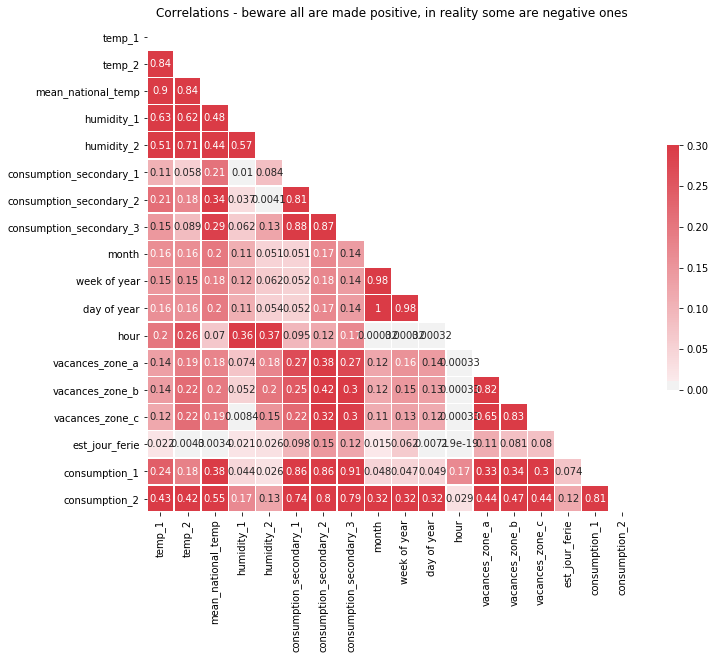

In [37]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title('Correlations - beware all are made positive, in reality some are negative ones')
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

There medium correlations between weather informations. The given sites have also positively correlated consumption, this makes sense because all sites are housings. The targets seem to be weakly correlated with time infos...

---

## Comparison between X_train & X_test

In [38]:
X_test = pd.read_csv(os.path.join(input_dir, 'input_test_cdKcI0e.csv'), index_col='ID')
X_test.iloc[23:26]

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
ID,,,,,,,,,,,,,,
8783,2017-11-01T23:00:00.0,9.0,9.0,9.4,78.0,95.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",172,131,170
8784,2017-11-02T00:00:00.0,8.8,8.6,9.4,79.0,95.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",172,136,172
8785,2017-11-02T01:00:00.0,7.6,8.8,9.4,82.0,96.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",174,126,171


In [39]:
df.shape, X_test.shape

((8760, 25), (8736, 14))

There are 24 lines (hours) more wich correspond to one day, because 2016 was a leap year

In [40]:
X_test.iloc[[0, -1]]

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
ID,,,,,,,,,,,,,,
8760,2017-11-01T00:00:00.0,6.5,7.1,8.8,91.0,82.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",190,126,177
17495,2018-10-30T23:00:00.0,7.5,11.2,6.7,85.0,77.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",228,114,178


In [41]:
df.iloc[[0, -1]]

,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,datetime,month,week of year,day of year,day,hour,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,est_jour_ferie
0,2016-11-01T00:00:00.0,8.3,14.5,11.1,95.0,65.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168,2016-11-01 00:00:00,11,44,306,Tuesday,0,2016-11-01,1,1,1,1.0
8759,2017-10-31T23:00:00.0,7.0,7.9,8.8,90.0,78.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",198,128,189,2017-10-31 23:00:00,10,44,304,Tuesday,23,2017-10-31,1,1,1,0.0


There is a difference in the length of the two dataframes X_train & X_test

---

# Data preparation

In [42]:
feat_to_drop = [
'timestamp',
'loc_1',
'loc_2',
'loc_secondary_1',
'loc_secondary_2',
'loc_secondary_3',
'datetime',
'date']

In [43]:
feat_to_scale = [
'temp_1',
'temp_2',
'mean_national_temp',
'humidity_1',
'humidity_2',
'consumption_secondary_1',
'consumption_secondary_2',
'consumption_secondary_3']

In [44]:
feat_to_dummies = [
'day',
'month',
'week of year',
#'day of year',
'hour']

Side note : let's try to run models without dummification of day of year

In [45]:
def prepare_feat_df(data_frame):
    data_frame = data_frame.drop(columns=feat_to_drop)
    data_frame[feat_to_scale] = MinMaxScaler().fit_transform(data_frame[feat_to_scale])
    data_frame = pd.get_dummies(data=data_frame, columns=feat_to_dummies, drop_first=True)
    return data_frame

In [46]:
df = prepare_feat_df(df)
df.head(2)

/home/sunflowa/Anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,day of year,vacances_zone_a,vacances_zone_b,vacances_zone_c,est_jour_ferie,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week of year_2,week of year_3,week of year_4,week of year_5,week of year_6,week of year_7,week of year_8,week of year_9,week of year_10,week of year_11,week of year_12,week of year_13,week of year_14,week of year_15,week of year_16,week of year_17,week of year_18,week of year_19,week of year_20,week of year_21,...,week of year_26,week of year_27,week of year_28,week of year_29,week of year_30,week of year_31,week of year_32,week of year_33,week of year_34,week of year_35,week of year_36,week of year_37,week of year_38,week of year_39,week of year_40,week of year_41,week of year_42,week of year_43,week of year_44,week of year_45,week of year_46,week of year_47,week of year_48,week of year_49,week of year_50,week of year_51,week of year_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.356234,0.466667,0.428571,0.936709,0.609195,0.155263,0.208451,0.155462,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.348601,0.466667,0.428571,0.974684,0.609195,0.150000,0.169014,0.142857,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Preparation

In [47]:
def prepare_data(input_file_name, output_file_name1, output_file_name2):
    data_frame = pd.read_csv(os.path.join(input_dir, input_file_name), index_col='ID')
    
    data_frame = transform_datetime_infos(data_frame)
    data_frame = merge_infos(data_frame)
    data_frame = cleaning_data(data_frame)
    data_frame = prepare_feat_df(data_frame)
    
    df_1 = data_frame.drop(columns=['temp_2', 'humidity_2'])
    df_2 = data_frame.drop(columns=['temp_1', 'humidity_1'])
    
    df_1.to_csv(os.path.join(output_dir, output_file_name1), index=False)
    df_2.to_csv(os.path.join(output_dir, output_file_name2), index=False)
    
    #return df_1, df_2

In [48]:
prepare_data('input_training_ssnsrY0.csv', 'X_train_1.csv', 'X_train_2.csv')
prepare_data('input_test_cdKcI0e.csv', 'X_test_1.csv', 'X_test_2.csv')

/home/sunflowa/Anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/sunflowa/Anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [49]:
pd.read_csv(os.path.join(output_dir, 'X_train_1.csv')).head()

,temp_1,mean_national_temp,humidity_1,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,day of year,vacances_zone_a,vacances_zone_b,vacances_zone_c,est_jour_ferie,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week of year_2,week of year_3,week of year_4,week of year_5,week of year_6,week of year_7,week of year_8,week of year_9,week of year_10,week of year_11,week of year_12,week of year_13,week of year_14,week of year_15,week of year_16,week of year_17,week of year_18,week of year_19,week of year_20,week of year_21,week of year_22,week of year_23,...,week of year_26,week of year_27,week of year_28,week of year_29,week of year_30,week of year_31,week of year_32,week of year_33,week of year_34,week of year_35,week of year_36,week of year_37,week of year_38,week of year_39,week of year_40,week of year_41,week of year_42,week of year_43,week of year_44,week of year_45,week of year_46,week of year_47,week of year_48,week of year_49,week of year_50,week of year_51,week of year_52,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.356234,0.428571,0.936709,0.155263,0.208451,0.155462,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.348601,0.428571,0.974684,0.150000,0.169014,0.142857,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.318066,0.425249,0.962025,0.152632,0.169014,0.147059,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.335878,0.421927,0.987342,0.144737,0.169014,0.142857,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.300254,0.418605,0.974684,0.184211,0.169014,0.147059,306,1,1,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
df_out['consumption_1'].to_csv(os.path.join('..', 'output', 'y_train_1.csv'), index=False)
df_out['consumption_2'].to_csv(os.path.join('..', 'output', 'y_train_2.csv'), index=False)

---

# Conclusion

In this first part, we've made an exploration of the data, thus you can see :
* how the weather (and particularly the temperature) could influence the electricity consumption. And the other correlations.
* how cyclic time infos are, and how the consumption vary depending on the hour of the day, the day of the week and the week of the year
Then we've have cleaned and prepared the datasets that will be used in the following part by the machine learning models.